Taller 5 - métodos computacionales 2

Catalina Fuentes y Silvana Archila

1.  Monte Carlo y la integral de camino de Feynman

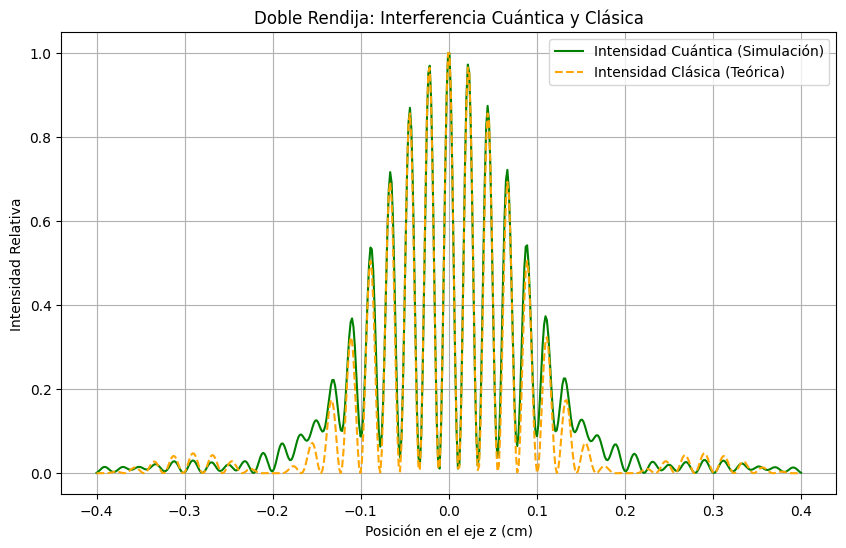

In [175]:
import numpy as np
import matplotlib.pyplot as plt


def intensidad_cuantica(posicion):
    integrando = np.exp((2j * np.pi * (distancia1 + distancia2)) / longitud_onda) * \
                 np.exp((1j * np.pi) / (longitud_onda * distancia1)) * (muestras_x - muestras_y)**2 * \
                 np.exp((1j * np.pi / (longitud_onda * distancia1)) * (posicion - muestras_y)**2)
    return np.abs(np.mean(integrando))**2 

def intensidad_clasica(posicion):
    angulo = np.arctan(posicion / distancia2)
    termino_sinc = (np.sinc((ancho_rendija / longitud_onda) * np.sin(angulo)))**2
    termino_cos = np.cos((np.pi * separacion / longitud_onda) * np.sin(angulo))**2
    return termino_cos * termino_sinc

#Parámetros
distancia1 = 30  
distancia2 = 30  
longitud_onda = 670e-7  
ancho_total = 0.1  
ancho_rendija = 0.01  
separacion = 0.09  
muestras = 100000  
rango_posicion = np.linspace(-0.4, 0.4, 500)  

#Genero muestras
muestras_x = np.random.uniform(-ancho_total / 2, ancho_total / 2, muestras)
muestras_y = np.concatenate((
    np.random.uniform(-ancho_rendija / 2 - separacion / 2, ancho_rendija / 2 - separacion / 2, muestras // 2),
    np.random.uniform(separacion / 2 - ancho_rendija / 2, separacion / 2 + ancho_rendija / 2, muestras // 2)
))

intensidades_cuanticas = np.array([intensidad_cuantica(pos) for pos in rango_posicion])
intensidades_cuanticas /= np.max(intensidades_cuanticas)

intensidades_clasicas = np.array([intensidad_clasica(pos) for pos in rango_posicion])
intensidades_clasicas /= np.max(intensidades_clasicas)

plt.figure(figsize=(10, 6))
plt.plot(rango_posicion, intensidades_cuanticas, label='Intensidad Cuántica (Simulación)', color='green')
plt.plot(rango_posicion, intensidades_clasicas, label='Intensidad Clásica (Teórica)', color='orange', linestyle='--')
plt.xlabel('Posición en el eje z (cm)')
plt.ylabel('Intensidad Relativa')
plt.title('Doble Rendija: Interferencia Cuántica y Clásica')
plt.legend()
plt.grid(True)
plt.show()


2. Metrópolis-Hastings para muestrear distribuciones 

2.a) Histograma comparado con distribución gamma.

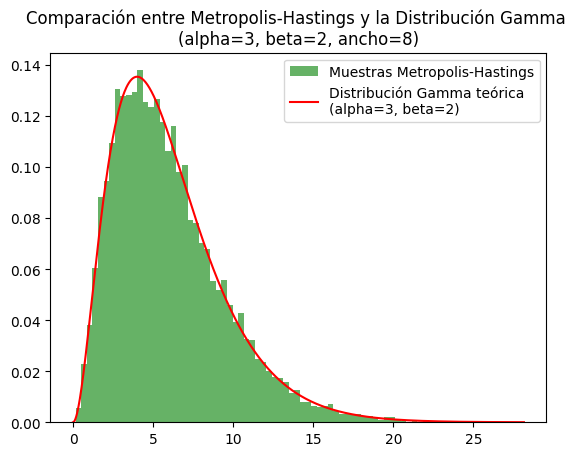

In [163]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

alpha = 3
beta = 2
ancho1 = 8
#función de la distribución Gamma 
def gamma_distr(x, alpha, beta):
    if x > 0:
        return x**(alpha - 1) * np.exp(-x / beta)
    else:
        return 0

#algoritmo de Metrópolis-Hastings
def metropolis_hastings_gamma(alpha, beta, N):
    x = np.random.rand()   
    samples = [x]
    
    for i in range(N):
        # Propuesta de un nuevo valor usando una distribución normal en torno al actual
        x_new = samples[-1] + np.random.normal(0, ancho1)
        
        # Calculamos la tasa de aceptación
        tasa = gamma_distr(x_new, alpha, beta) / gamma_distr(x, alpha, beta)
        
        # Aceptamos o rechazamos la propuesta
        if np.random.rand() < tasa:
            x = x_new
        
        samples.append(x)
    
    return np.array(samples)

N = 30000
samples = metropolis_hastings_gamma(alpha, beta, N)

#Histograma
plt.hist(samples, bins=80, density=True, alpha=0.6, color='g', label="Muestras Metropolis-Hastings")

#Función Gamma
x = np.linspace(0, np.max(samples), 1000)
plt.plot(x, stats.gamma.pdf(x, a=alpha, scale=beta), 'r-', label=f"Distribución Gamma teórica \n(alpha={alpha}, beta={beta})")

plt.legend()
plt.title(f"Comparación entre Metropolis-Hastings y la Distribución Gamma \n(alpha={alpha}, beta={beta}, ancho={ancho1})")
plt.show()


2.b) Recuperación de los parámetros alfa y beta

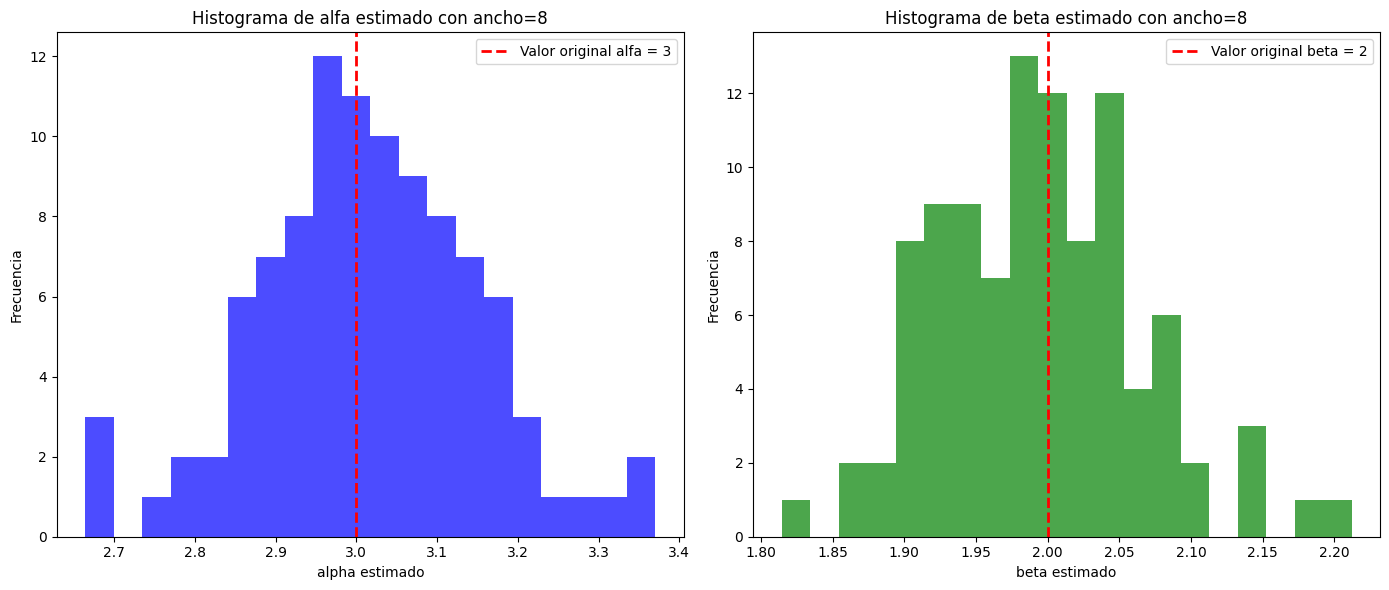

In [164]:
repeticiones = 100
N = 10000

alpha_estimados = []
beta_estimados = []

for i in range(repeticiones):
    samples = metropolis_hastings_gamma(alpha, beta, N)
    alpha_hat, loc, beta_hat = stats.gamma.fit(samples, scale=1)  
    alpha_estimados.append(alpha_hat)
    beta_estimados.append(beta_hat)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

#Histograma de alfa estimado
ax1.hist(alpha_estimados, bins=20, color='blue', alpha=0.7)
ax1.axvline(alpha, color='red', linestyle='dashed', linewidth=2, label=f'Valor original alfa = {alpha}')
ax1.set_title(f'Histograma de alfa estimado con ancho={ancho1}')
ax1.set_xlabel('alpha estimado')
ax1.set_ylabel('Frecuencia')
ax1.legend()

#Histograma de beta estimado
ax2.hist(beta_estimados, bins=20, color='green', alpha=0.7)
ax2.axvline(beta, color='red', linestyle='dashed', linewidth=2, label=f'Valor original beta = {beta}')
ax2.set_title(f'Histograma de beta estimado con ancho={ancho1}')
ax2.set_xlabel('beta estimado')
ax2.set_ylabel('Frecuencia')
ax2.legend()

plt.tight_layout()
plt.show()


In [165]:
desviacion_alpha = np.std(alpha_estimados)
desviacion_beta = np.std(beta_estimados)
print(f"La desviación estándar de alfa para un ancho={ancho1} es {desviacion_alpha}")
print(f"La desviación estándar de alfa para un ancho={ancho1} es {desviacion_beta}")

La desviación estándar de alfa para un ancho=8 es 0.13707514891877187
La desviación estándar de alfa para un ancho=8 es 0.07106282444226364


Con un ancho de la distribución de perturbación de 6, la desviación estándar de las estimaciones de alfa indica una dispersión moderada en las estimaciones. Para beta la desviación estándar fue más pequeña, lo que sugiere que las estimaciones de beta fueron más precisas. En general, el ajuste del ancho permitió recuperar los parámetros con buena precisión, especialmente en el caso de beta, donde la variabilidad fue menor.

2.c) Desviación estándar de los histogramas para distintos anchos de la distribución de perturbación

Probamos con un ancho mucho menor al utilizado anteriormente.

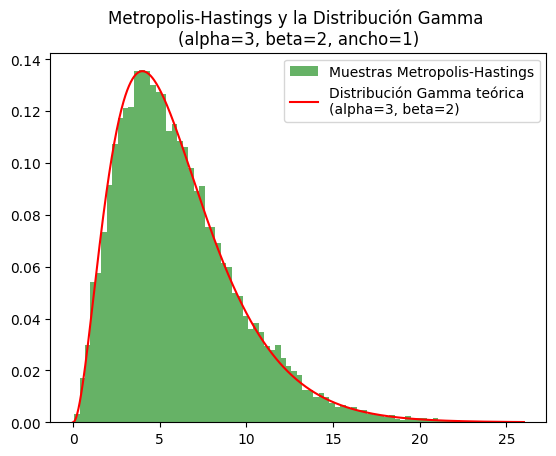

In [166]:
ancho2 = 1
def metropolis_hastings_gamma(alpha, beta, N):
    x = np.random.rand()   
    samples = [x]
    
    for i in range(N):
        # Propuesta de un nuevo valor usando una distribución normal en torno al actual
        x_new = samples[-1] + np.random.normal(0, ancho2) 
        
        # Calculamos la tasa de aceptación
        tasa = gamma_distr(x_new, alpha, beta) / gamma_distr(x, alpha, beta)
        
        # Aceptamos o rechazamos la propuesta
        if np.random.rand() < tasa:
            x = x_new
        
        samples.append(x)
    
    return np.array(samples)

N = 30000
samples2 = metropolis_hastings_gamma(alpha, beta, N)

#Histograma
plt.hist(samples2, bins=80, density=True, alpha=0.6, color='g', label="Muestras Metropolis-Hastings")

#Función Gamma
x = np.linspace(0, np.max(samples), 1000)
plt.plot(x, stats.gamma.pdf(x, a=alpha, scale=beta), 'r-', label=f"Distribución Gamma teórica \n(alpha={alpha}, beta={beta})")

plt.legend()
plt.title(f"Metropolis-Hastings y la Distribución Gamma \n(alpha={alpha}, beta={beta}, ancho={ancho2})")
plt.show()


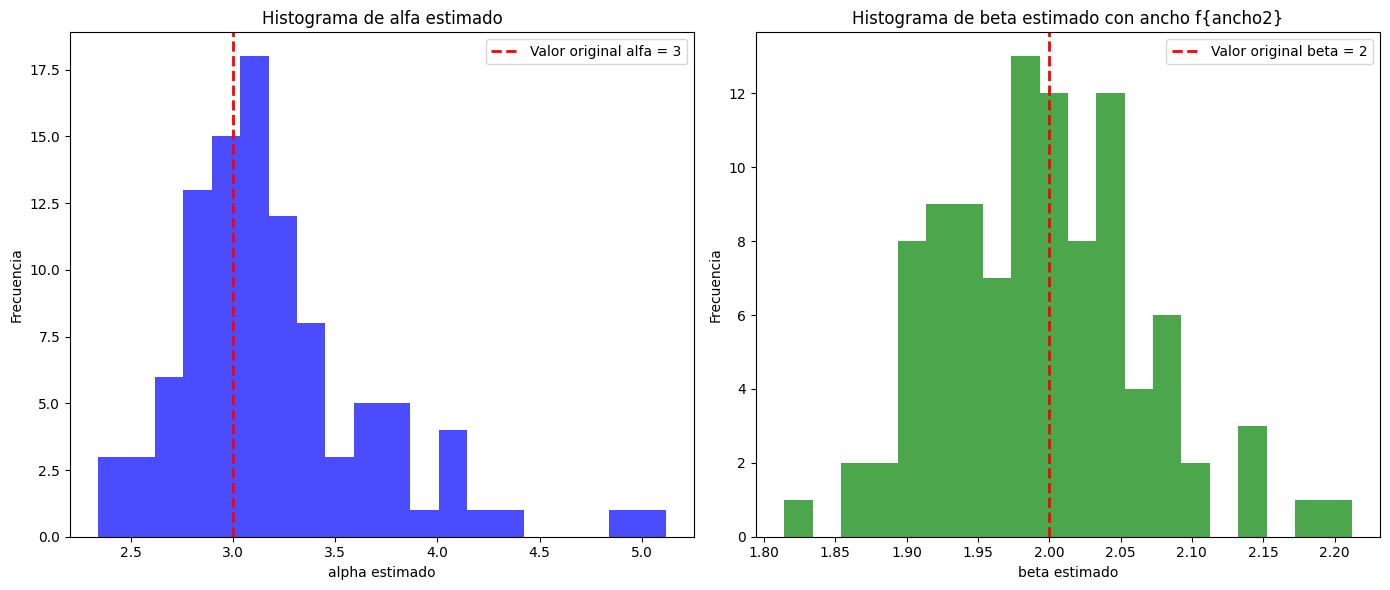

In [167]:
repeticiones = 100
N = 10000

alpha_estimados2 = []
beta_estimados2 = []

for i in range(repeticiones):
    samples = metropolis_hastings_gamma(alpha, beta, N)
    alpha_hat, loc, beta_hat = stats.gamma.fit(samples, scale=1)  
    alpha_estimados2.append(alpha_hat)
    beta_estimados2.append(beta_hat)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

#Histograma de alfa estimado
ax1.hist(alpha_estimados2, bins=20, color='blue', alpha=0.7)
ax1.axvline(alpha, color='red', linestyle='dashed', linewidth=2, label=f'Valor original alfa = {alpha}')
ax1.set_title('Histograma de alfa estimado')
ax1.set_xlabel('alpha estimado')
ax1.set_ylabel('Frecuencia')
ax1.legend()

#Histograma de beta estimado
ax2.hist(beta_estimados, bins=20, color='green', alpha=0.7)
ax2.axvline(beta, color='red', linestyle='dashed', linewidth=2, label=f'Valor original beta = {beta}')
ax2.set_title('Histograma de beta estimado con ancho f{ancho2}')
ax2.set_xlabel('beta estimado')
ax2.set_ylabel('Frecuencia')
ax2.legend()

plt.tight_layout()
plt.show()

Probamos con un ancho mucho mayor al utilizado anteriormente.

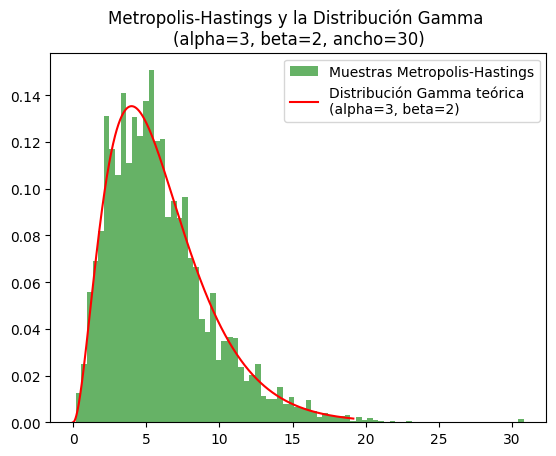

In [168]:
ancho3 = 30
def metropolis_hastings_gamma(alpha, beta, N):
    x = np.random.rand()   
    samples = [x]
    
    for i in range(N):
        # Propuesta de un nuevo valor usando una distribución normal en torno al actual
        x_new = samples[-1] + np.random.normal(0, ancho3) 
        
        # Calculamos la tasa de aceptación
        tasa = gamma_distr(x_new, alpha, beta) / gamma_distr(x, alpha, beta)
        
        # Aceptamos o rechazamos la propuesta
        if np.random.rand() < tasa:
            x = x_new
        
        samples.append(x)
    
    return np.array(samples)

N = 30000
samples2 = metropolis_hastings_gamma(alpha, beta, N)

#Histograma
plt.hist(samples2, bins=80, density=True, alpha=0.6, color='g', label="Muestras Metropolis-Hastings")

#Función Gamma
x = np.linspace(0, np.max(samples), 1000)
plt.plot(x, stats.gamma.pdf(x, a=alpha, scale=beta), 'r-', label=f"Distribución Gamma teórica \n(alpha={alpha}, beta={beta})")

plt.legend()
plt.title(f"Metropolis-Hastings y la Distribución Gamma \n(alpha={alpha}, beta={beta}, ancho={ancho3})")
plt.show()


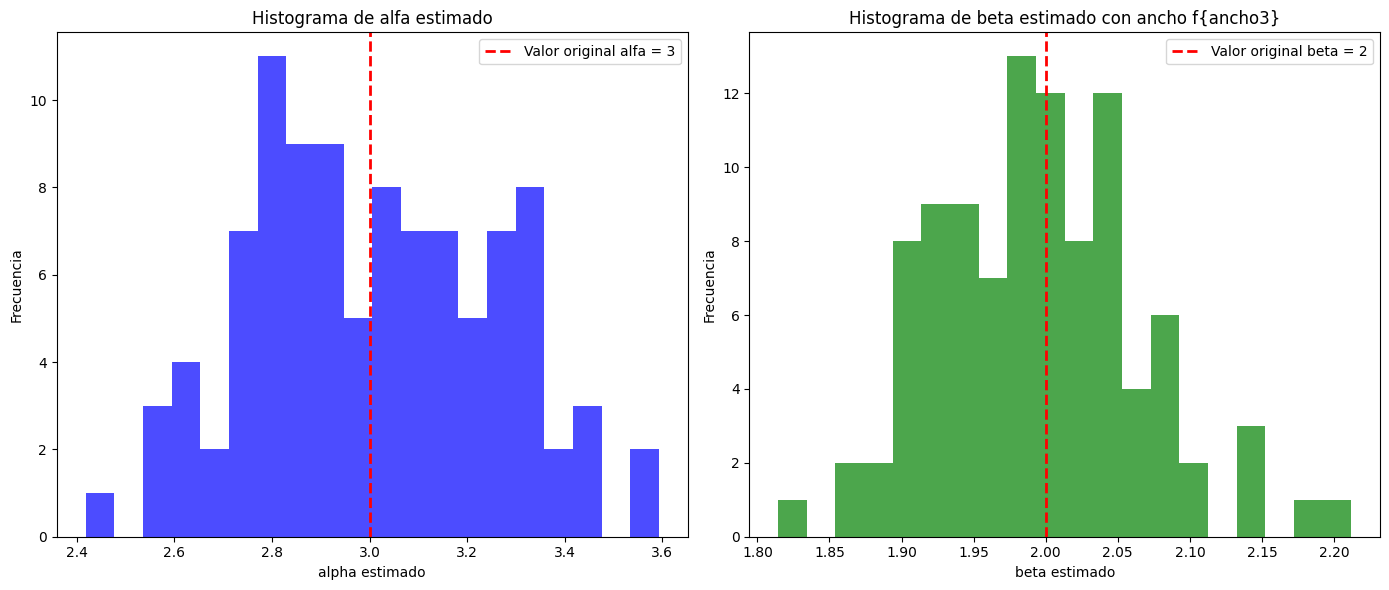

In [169]:
repeticiones = 100
N = 10000

alpha_estimados3 = []
beta_estimados3 = []

for i in range(repeticiones):
    samples = metropolis_hastings_gamma(alpha, beta, N)
    alpha_hat, loc, beta_hat = stats.gamma.fit(samples, scale=1)  
    alpha_estimados3.append(alpha_hat)
    beta_estimados3.append(beta_hat)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

#Histograma de alfa estimado
ax1.hist(alpha_estimados3, bins=20, color='blue', alpha=0.7)
ax1.axvline(alpha, color='red', linestyle='dashed', linewidth=2, label=f'Valor original alfa = {alpha}')
ax1.set_title('Histograma de alfa estimado')
ax1.set_xlabel('alpha estimado')
ax1.set_ylabel('Frecuencia')
ax1.legend()

#Histograma de beta estimado
ax2.hist(beta_estimados, bins=20, color='green', alpha=0.7)
ax2.axvline(beta, color='red', linestyle='dashed', linewidth=2, label=f'Valor original beta = {beta}')
ax2.set_title('Histograma de beta estimado con ancho f{ancho3}')
ax2.set_xlabel('beta estimado')
ax2.set_ylabel('Frecuencia')
ax2.legend()

plt.tight_layout()
plt.show()

Comparamos las 3 desviaciones

In [171]:
desviacion_alpha = np.std(alpha_estimados)
desviacion_beta = np.std(beta_estimados)
print(f"La desviación estándar de alfa para un ancho={ancho1} es {desviacion_alpha}")
print(f"La desviación estándar de beta para un ancho={ancho1} es {desviacion_beta}")

desviacion_alpha2 = np.std(alpha_estimados2)
desviacion_beta2 = np.std(beta_estimados2)
print(f"La desviación estándar de alfa para un ancho={ancho2} es {desviacion_alpha2}")
print(f"La desviación estándar de beta para un ancho={ancho2} es {desviacion_beta2}")

desviacion_alpha3 = np.std(alpha_estimados3)
desviacion_beta3 = np.std(beta_estimados3)
print(f"La desviación estándar de alfa para un ancho={ancho3} es {desviacion_alpha3}")
print(f"La desviación estándar de beta para un ancho={ancho3} es {desviacion_beta3}")

La desviación estándar de alfa para un ancho=8 es 0.13707514891877187
La desviación estándar de beta para un ancho=8 es 0.07106282444226364
La desviación estándar de alfa para un ancho=1 es 0.4846690554609212
La desviación estándar de beta para un ancho=1 es 0.27816767987987623
La desviación estándar de alfa para un ancho=30 es 0.2539178590012238
La desviación estándar de beta para un ancho=30 es 0.1376473221421799


De las desviaciones estándar anteriores determinamos que el ancho=8 es el mejor, ya que produce las desviaciones estándar más bajas tanto para alfa como para beta. El ancho de 1 genera desviaciones estándar más altas, lo que indica mayor dispersión en las estimaciones. Por otro lado, un ancho de 30 también genera desviaciones más grandes, aunque menores que el ancho de 1.

El ancho de perturbación afecta la precisión de las estimaciones porque controla qué tan grandes son los saltos propuestos en el algoritmo de Metrópolis-Hastings. Con un ancho muy pequeño (como el de 1), el algoritmo hace pequeños saltos, lo que lleva a una exploración lenta del espacio de parámetros, aumentando la variabilidad. Con un ancho muy grande (como el de 30), se generan saltos demasiado amplios, lo que disminuye la tasa de aceptación y aumenta la dispersión. Un ancho moderado (como 8) logra un buen balance entre exploración y aceptación, lo que produce histogramas más precisos que generan mejores aproximaciones de alfa y beta.

5. Evolución temporal de procesos estocásticos discretos

5.1) Sistema determinista

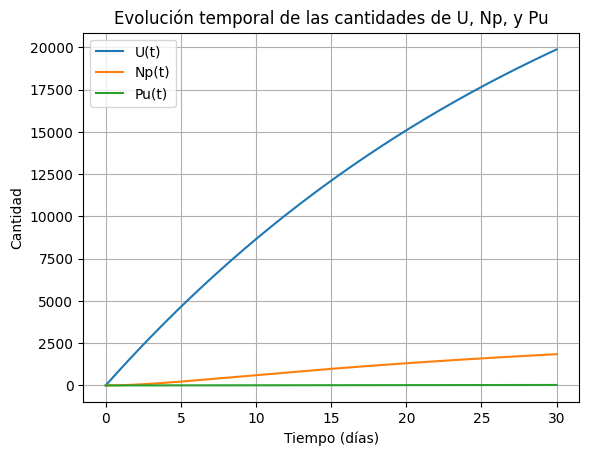

In [172]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constantes proporcionadas
A = 1000  # Creación de 239-U por día
B = 20  # Extracción de plutonio por día
t_half_U = 23.4  # Vida media de 239-U en días
t_half_Np = 2.36  # Vida media de 239-Np en días

# Constantes de desintegración lambda
lambda_U = np.log(2) / t_half_U
lambda_Np = np.log(2) / t_half_Np

# Definición del sistema de ecuaciones diferenciales
def sistema(t, y):
    U, Np, Pu = y
    dU_dt = A - lambda_U * U
    dNp_dt = lambda_U * U - lambda_Np * Np
    dPu_dt = lambda_Np * Np - B * Pu
    return [dU_dt, dNp_dt, dPu_dt]

# Condiciones iniciales: planta completamente limpia (U = Np = Pu = 0 al inicio)
y0 = [0, 0, 0]

# Simular 30 días
t_span = (0, 30)
t_eval = np.linspace(0, 30, 300)

# Resolver el sistema de ecuaciones diferenciales
sol = solve_ivp(sistema, t_span, y0, t_eval=t_eval)

# Graficar los resultados
plt.plot(sol.t, sol.y[0], label="U(t)")
plt.plot(sol.t, sol.y[1], label="Np(t)")
plt.plot(sol.t, sol.y[2], label="Pu(t)")
plt.xlabel("Tiempo (días)")
plt.ylabel("Cantidad")
plt.title("Evolución temporal de las cantidades de U, Np, y Pu")
plt.legend()
plt.grid(True)
plt.show()

#NO SE SI ESTO ESTA BIEN O NO :(